# Телеком — задача проекта

## Описание проекта

Оператор связи  хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.


### Содержание

1.[Изучение данных](#1)

2.[План работы](#2)

3.[Предобработка данных](#3)

4.[Исследовательский анализ данных](#4)

5.[Итоговое тестирование модели](#5)

6.[Вывод](#6)

7.[Отчет о проделанной работе](#7)




<a id='1'></a>
## Изучение данных

In [1]:
import pandas as pd
import numpy as np

import os

#Графические библиотеки
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure as fg
import plotly.figure_factory as ff
import phik
from phik.report import plot_correlation_matrix
from phik import report

#Предобработка
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

#Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

#Метрики
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold 

#Подбор гиперпараметров
import optuna
from optuna.samplers import TPESampler

In [2]:
# Загрузка данных
path = '/datasets/final_provider/'

# информация о договоре    
if os.path.exists(path+'contract.csv'):
    df_contract =  pd.read_csv(path+'contract.csv')
elif os.path.exists('contract.csv'):
    df_contract = pd.read_csv('contract.csv')
    
# персональные данные клиента
if os.path.exists(path+'personal.csv'):
    df_personal =  pd.read_csv(path+'personal.csv')
elif os.path.exists('personal.csv'):
    df_personal = pd.read_csv('personal.csv')
    
# информация об интернет-услугах
if os.path.exists(path+'internet.csv'):
    df_internet =  pd.read_csv(path+'internet.csv')
elif os.path.exists('internet.csv'):
    df_internet = pd.read_csv('internet.csv')

# информация об услугах телефонии
if os.path.exists(path+'phone.csv'):
    df_phone =  pd.read_csv(path+'phone.csv')
elif os.path.exists('phone.csv'):
    df_phone = pd.read_csv('phone.csv')

### Договоры с потребителями

In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
df_contract.columns = df_contract.columns.str.lower()

In [6]:
df_contract.loc[df_contract['totalcharges'] == ' '].head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,


In [7]:
df_contract['totalcharges'] = pd.to_numeric(df_contract['totalcharges'], downcast='float', errors ='coerce')
df_contract['begindate'] = pd.to_datetime(df_contract['begindate'])
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'], errors ='coerce')

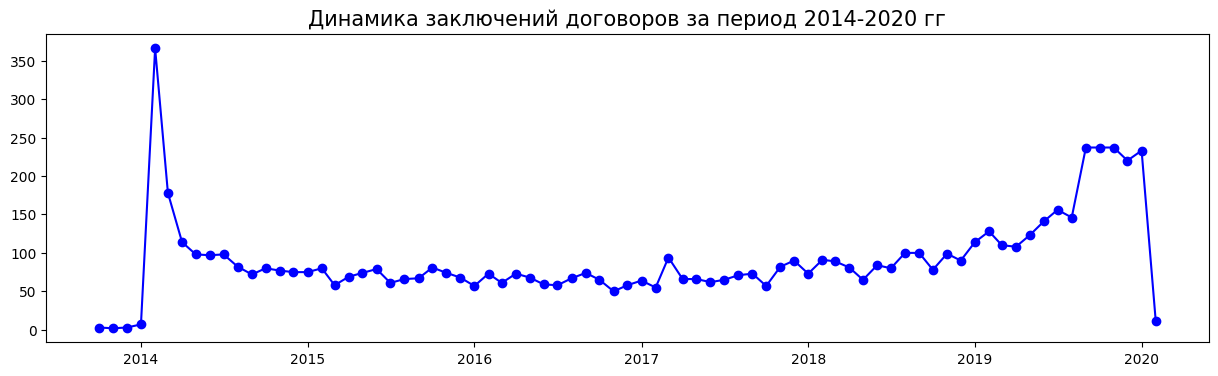

In [8]:
group_bd = df_contract.groupby('begindate').agg({'begindate': 'count'})
fig = plt.gcf()
plt.plot(group_bd.index, 'begindate', data=group_bd, linestyle='-', marker='o', color="blue")
plt.title('Динамика заключений договоров за период 2014-2020 гг', size=15)
fig.set_size_inches(15, 4)
plt.show()

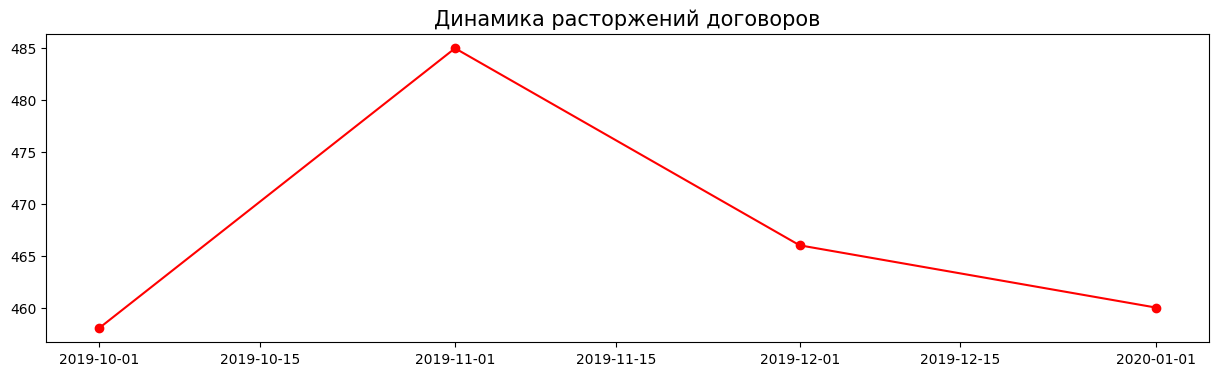

In [9]:
group_ed = df_contract.groupby('enddate').agg({'enddate': 'count'})
fig = plt.gcf()
plt.plot(group_ed.index, 'enddate', data=group_ed, linestyle='-', marker='o', color="red")
plt.title('Динамика расторжений договоров', size=15)
fig.set_size_inches(15, 4)
plt.show()

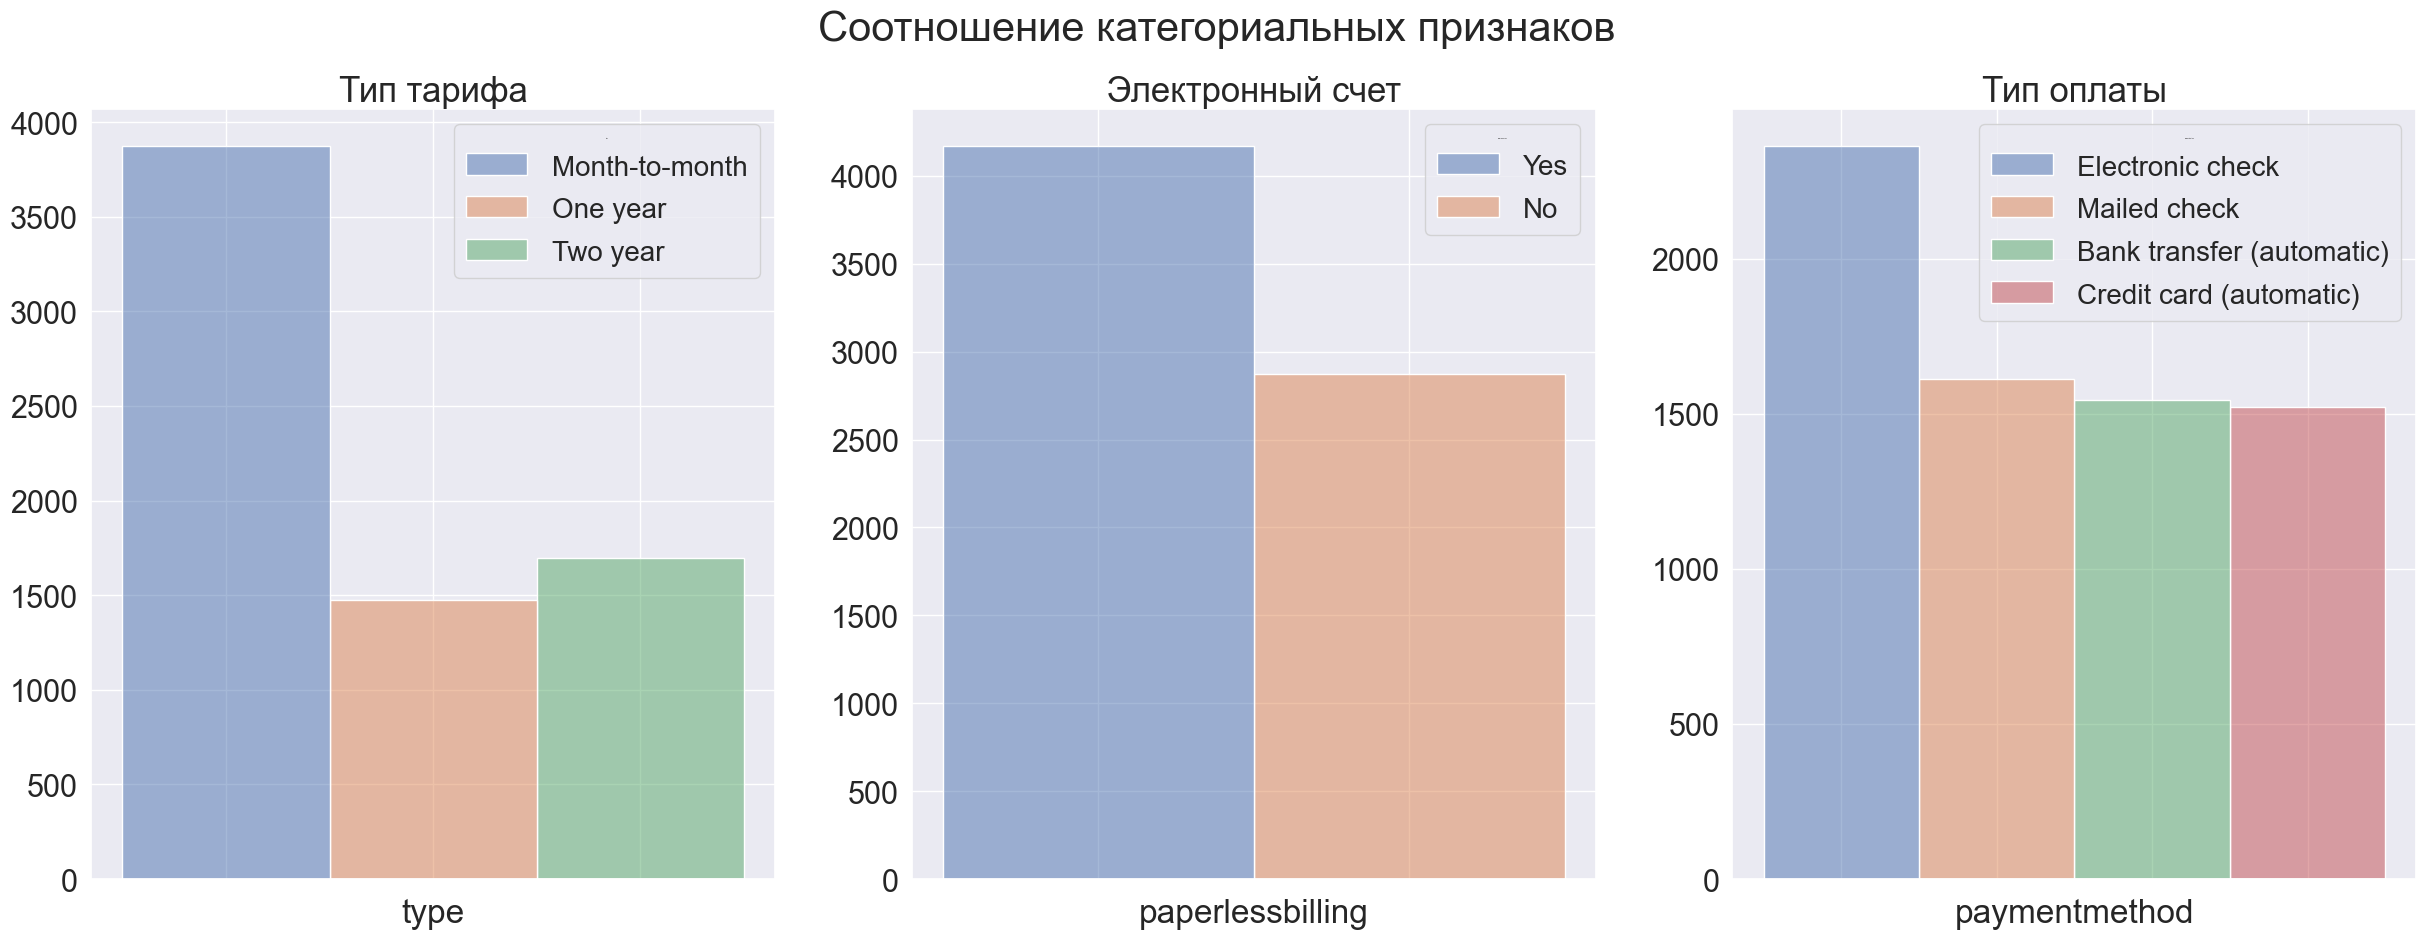

In [10]:
category = ['type', 'paperlessbilling', 'paymentmethod']
titles = ['Тип тарифа', 'Электронный счет', 'Тип оплаты']
sns.set(font_scale=2)  
fig, axs = plt.subplots(1, len(category), figsize=(30, 10))
fig.suptitle('Соотношение категориальных признаков', fontsize=30)

for cat, ax, tit in zip(category, axs, titles):   
    ax.set_title(tit, size=25) 
    sns.histplot(df_contract, x=cat, hue=cat, ax=ax,  legend=True)
    ax.xaxis.set_ticklabels([])
    ax.set(ylabel='') 
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    plt.setp(ax.get_legend().get_title(), fontsize='0')  
plt.show()

In [11]:
df_contract.describe()

,monthlycharges,totalcharges
count,7043.000000,7032.000000
mean,64.761692,2283.300537
std,30.090047,2266.771484
min,18.250000,18.799999
25%,35.500000,401.450012
50%,70.350000,1397.475098
75%,89.850000,3794.737549
max,118.750000,8684.799805


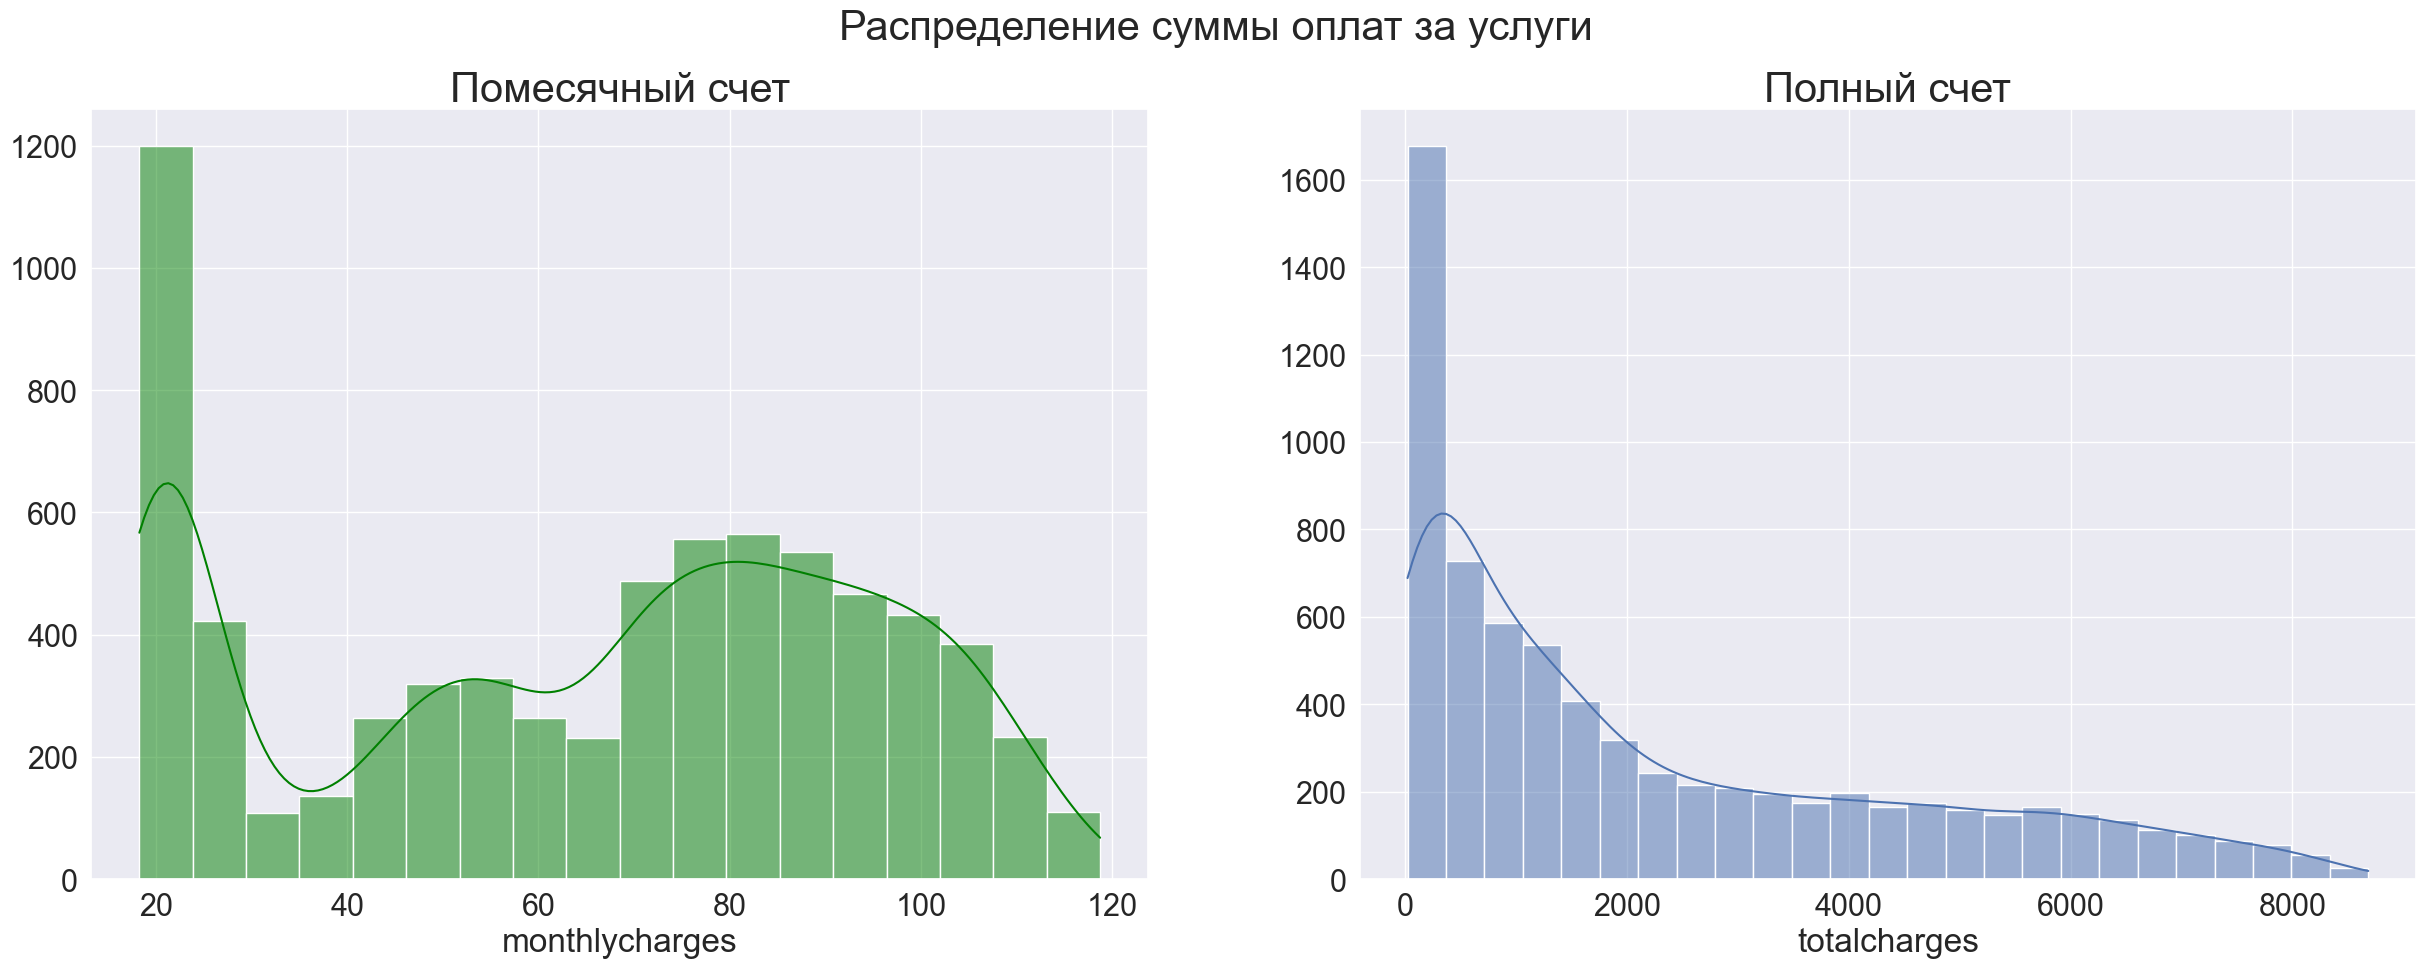

In [12]:
sns.set(font_scale=2)  
fig, axs = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('Распределение суммы оплат за услуги', fontsize=30)
sns.histplot(data=df_contract, x="monthlycharges", ax=axs[0], kde=True, color='green').set_title('Помесячный счет', size=30)
#axs[0].set(xlabel='')
axs[0].set(ylabel='')
sns.histplot(data=df_contract, x="totalcharges",  ax=axs[1], kde=True).set_title('Полный счет', size=30)
#axs[1].set(xlabel='')
axs[1].set(ylabel='')
plt.show()

Данные о договорах предоставлены за период 2013-10-01 - 2020-02-01. В этих датах заключались новые договора. Пик заключенных договоров пришелся на 2014 и 2019 гг.

Расторгались договора в период с 2019-10-01 по 2020-01-01.

Потребители предпочитают помесячный тип оплаты остальным. Практически одинаковый спрос у типов оплаты за год и за два.
Также чаще выбирают электронный способ оплаты услуг.

### Персональные данные клиента

In [13]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
df_personal.columns = df_personal.columns.str.lower()

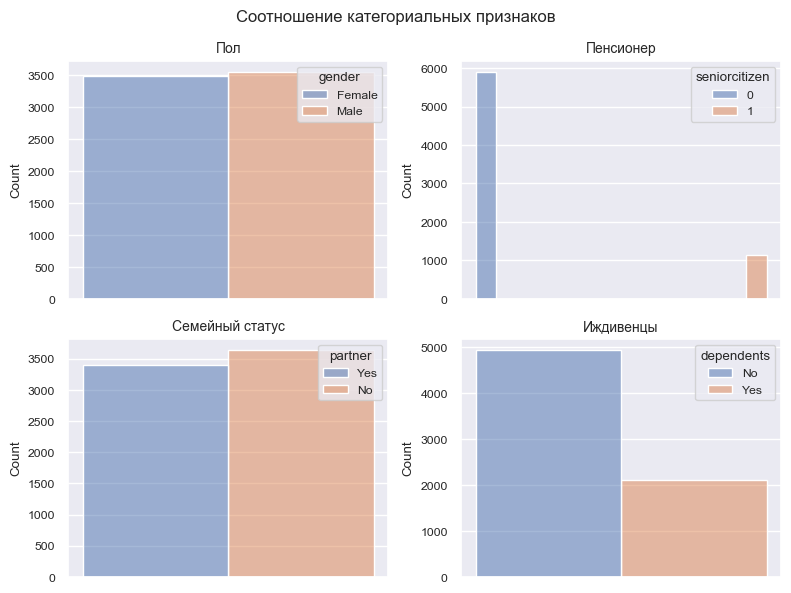

In [16]:
sns.set(font_scale=0.8)
fig = plt.figure(figsize=(8,6))
category = df_personal.drop(columns=['customerid']).columns
fig.suptitle('Соотношение категориальных признаков', fontsize=12)
titles = ['Пол', 'Пенсионер', 'Семейный статус', 'Иждивенцы']
sns.color_palette("flare")
for i, cat in zip(range(4), category):
    fig.add_subplot(2, 2, i+1)
    plt.xticks([])
    #plt.yticks([])
    sns.histplot(df_personal, x=cat, hue=cat,  legend=True).set_title(titles[i], size=10)
    plt.tight_layout()

Среди пользователей услуг интернета и телевидения почти одинаковое количество мужчин и женщин, женатых и неженатых.   
Небольшими группами пользователей являются пенсионеры и люди, на попечении которых есть иждивенцы.


### Информация об интернет-услугах

In [17]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
df_internet.columns = df_internet.columns.str.lower()

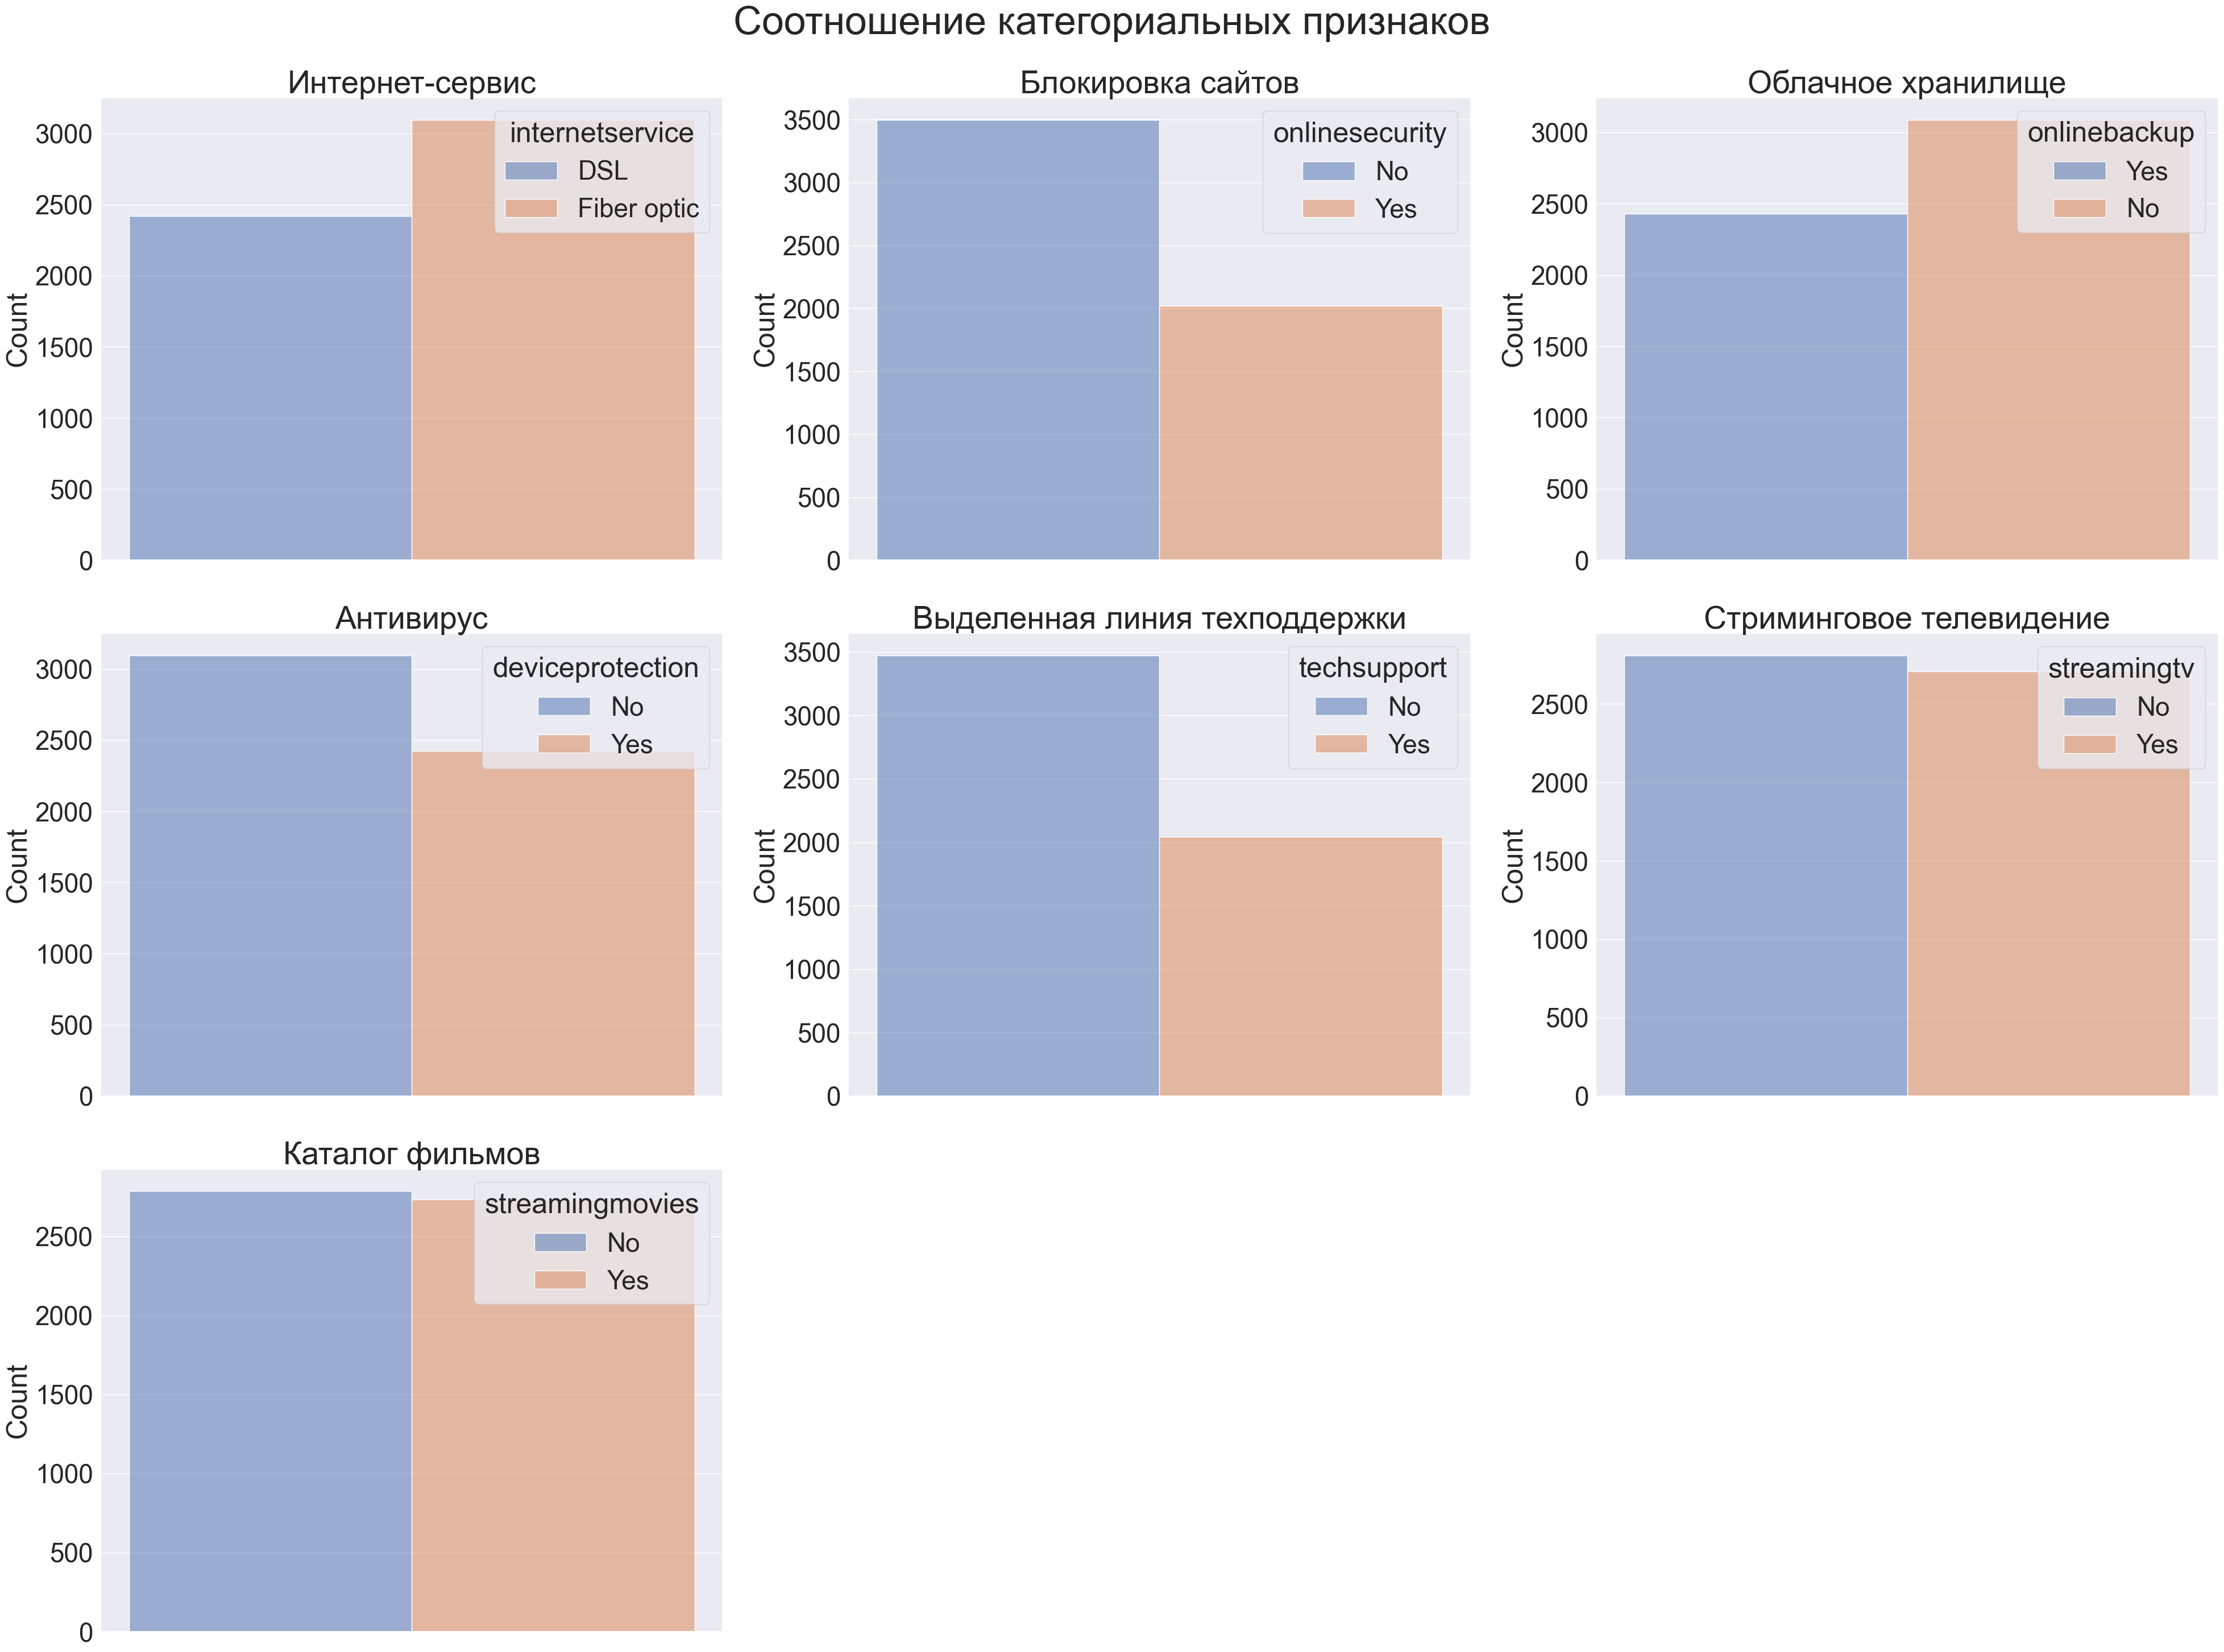

In [20]:
sns.set(font_scale=3)
titles = [
        'Интернет-сервис', 
        'Блокировка сайтов', 
        'Облачное хранилище', 
        'Антивирус', 
        'Выделенная линия техподдержки', 
        'Стриминговое телевидение',
         'Каталог фильмов'
]
fig = plt.figure(figsize=(40,30))
category = df_internet.drop(columns=['customerid']).columns
fig.suptitle('Соотношение категориальных признаков', fontsize=50)
for i, cat in zip(range(7), category):
    fig.add_subplot(3, 3, i+1)
    plt.xticks([])
    #plt.yticks([])
    sns.histplot(df_internet, x=cat, hue=cat,  legend=True).set_title(titles[i], size=40)
    plt.tight_layout()

Bсе предоставляемые дополнительные услуги так или иначе приобретаются пользователями.  
Более популярно подключение интернета через оптоволоконную линию, менее через цифровую абонентскую линию.

### Информация об услугах телефонии

In [21]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [22]:
df_phone.columns = df_phone.columns.str.lower()

In [23]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


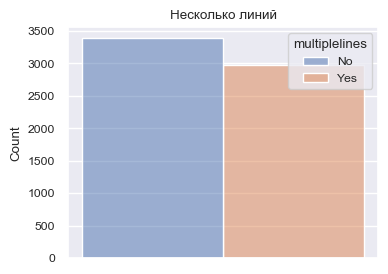

In [24]:
sns.set(font_scale=0.8)
fg(figsize=(4,3))
plt.xticks([])
sns.histplot(df_phone, x='multiplelines', hue='multiplelines',  legend=True)
plt.title('Несколько линий')
plt.show()

Чуть менее популярно наличие нескольких телефонных линий.

<a id='2'></a>
## План работы

1. Предобработка данных.  
   1.1 Совместим исходные датафреймы.   
   1.2 Заполним пропуски.  
   1.3 Сгенерируем целевую переменную "terminated" из EndDate. Если дата пропущена, будем считать, что клиент не расторг договор.    
   1.4 Сгенерируем доп. признаки(сколько пользователь является клиентом, разница средней помесячной оплаты и оплаты на текущий месяц и тд.)    
   1.5 Удалим признаки EndDate и BeginDatе во избежание утечки целевой переменной.    
   
   
2. Исследовательский анализ данных.  
   2.1 Проверим, есть ли аномалии в данных.  
   2.2 Исследуем признаки будущих моделей, исследуем корреляцию.  
   2.3 Проведем отбор признаков.
   
   
3. Обучение модели.  
   3.1 Разделим данные на тренировочную и тестовую выборки (test = 0.25*train).  
   3.2 Обучим несколько моделей, создадим "pipeline" из предобработки и модели.  
       3.2.1 Закодируем категориальные переменные "OneHotEncorer".  
       3.2.2 Применим "upsampling" для учета дисбаланса классов.  
       3.2.3 Применим "StandartScaller" для линейной модели. 
     
     
4. Анализ моделей.   
   Выберем лучшую модель по итогам кросс-валидации на "train". 
   В качестве основной метрики применим ROC_AUC, дополнительной - accuracy.
   
   
5. Итоговое тестирование модели.  
   5.1 Для лучшей модели изучим важность признаков, при необходимости проведем их отбор и заново обучим модель.  
   5.2 Оценим качество модели на контрольной выборке.
   
  
  
6. Вывод.

Вопросов не возникло.

<a id='3'></a>
## Предобработка данных

### Соединим исходные датафреймы.

In [25]:
df = df_contract.\
     merge(df_personal, on='customerid', how='outer').\
     merge(df_internet, on='customerid', how='outer').\
     merge(df_phone, on='customerid', how='outer')

In [26]:
df.sample(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
2501,6585-WCEWR,2014-02-01,NaT,Two year,No,Electronic check,20.35,1354.400024,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1363,3084-DOWLE,2014-02-01,NaT,Two year,No,Bank transfer (automatic),92.00,6474.399902,Female,0,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6438,3551-HUAZH,2019-09-01,2019-10-01,Month-to-month,Yes,Electronic check,74.40,74.400002,Male,1,No,No,Fiber optic,No,No,No,No,No,No,Yes
2797,6023-YEBUP,2019-09-01,2019-12-01,Month-to-month,Yes,Electronic check,100.95,329.950012,Male,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
1368,6250-CGGUN,2015-08-01,NaT,One year,No,Electronic check,84.40,4484.049805,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,No,No,No


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float32       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

In [28]:
df.isna().sum()

customerid             0
begindate              0
enddate             5174
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges          11
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
multiplelines        682
dtype: int64

In [29]:
df.duplicated().sum()

0

### Заполним пропуски


In [30]:
df.loc[df['totalcharges'].isna()].sample(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
6754,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes


Видим, что пропуски в 'totalcharges' образовались у тех пользователей, которые недавно заключили договор.
Заполним их значениями в 'monthlycharges'. Эта сумма и является полной потраченной на услуги суммой.

In [31]:
df.loc[df['totalcharges'].isna(), 'totalcharges'] = df['monthlycharges']

In [32]:
df.loc[df['internetservice'].isna()].sample(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
3359,3623-FQBOX,2018-05-01,NaT,Month-to-month,Yes,Mailed check,19.95,416.399994,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
967,7764-BDPEE,2019-11-01,NaT,Month-to-month,No,Mailed check,20.85,60.650002,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1937,0854-UYHZD,2019-01-01,NaT,Two year,No,Mailed check,19.55,265.299988,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4468,7083-YNSKY,2018-07-01,2019-10-01,Month-to-month,Yes,Credit card (automatic),25.40,399.600006,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
6010,3460-TJBWI,2018-02-01,NaT,Two year,No,Mailed check,24.20,609.049988,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes


Пропуски в данных об интернет-услугах образовались скорее из-за того, что эти услуги предоставлены не всем пользователям. Заполним значением "No" все пропуски, связанные с предоставлением интернет-услуг.

In [33]:
for col in df_internet.columns.to_list():
    df[col] = df[col].fillna("No")

In [34]:
df.loc[df['multiplelines'].isna()].sample(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
1122,4081-DYXAV,2018-03-01,2019-10-01,One year,Yes,Credit card (automatic),44.85,893.549988,Female,0,No,No,DSL,No,No,No,No,Yes,Yes,NaN
875,3050-GBUSH,2019-11-01,NaT,Month-to-month,Yes,Credit card (automatic),34.80,113.949997,Female,0,No,No,DSL,No,No,No,No,Yes,No,NaN
718,1853-ARAAQ,2017-12-01,NaT,Month-to-month,Yes,Credit card (automatic),50.35,1277.500000,Female,0,No,No,DSL,No,No,Yes,No,Yes,Yes,NaN
5163,3472-OAOOR,2018-07-01,NaT,Month-to-month,Yes,Mailed check,34.95,610.200012,Male,0,Yes,Yes,DSL,Yes,Yes,No,No,No,No,NaN
5411,7932-WPTDS,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,24.80,24.799999,Female,1,Yes,No,DSL,No,No,No,No,No,No,NaN


In [35]:
df.loc[df['multiplelines'].isna(), 'internetservice'].value_counts()

DSL    682
Name: internetservice, dtype: int64

Данных о многоканальной связи нет для пользователей, использующих цифровую абонентскую линию для интернета, предположим, что пропуск означал, что многоканальная связь отсуствует.

In [36]:
df['multiplelines'] = df['multiplelines'].fillna('No')

Сделаем индексом 'customerid

In [37]:
df = df.set_index('customerid')

### Сгенерируем целевой признак

Если пользователь ушел, целевую переменную примем равную "1", если остался - "0"

In [38]:
df['terminated'] = 1

In [39]:
df.loc[df['enddate'].isna(), 'terminated'] = 0

### Сгенерируем дополнительные признаки

Для улучшения модели добавим 2 дополнительных признака.

In [40]:
df.loc[df['enddate'].isna(), 'enddate'] = df['begindate'].max()

Длительность оказания услуг.

In [41]:
df['duration'] = (df['enddate'] - df['begindate'])  / pd.Timedelta("1 days")

Отношение оплаты на текущий месяц и средней помесячной оплаты

In [42]:
df['diffcharges'] =  df['monthlycharges'] /(df['totalcharges'] / df['duration'])

In [43]:
df.loc[df['diffcharges'] == np.inf * -1, 'diffcharges'] = 0

### Удалим признаки 'enddate' и 'begindate' во избежания утечки целевой переменной

In [44]:
df = df.drop(columns=['enddate', 'begindate'])

<a id='4'></a>
## Исследовательский анализ данных                                                                                                       
### Проверим данные на наличие аномалий, исследуем признаки будущих моделей.

#### Анализ признаков будем проводить для 2-ух групп:  
1 - ушедшие пользователи;  
2 - оставшиеся.     

#### Исследуем числовые признаки для 2-ух групп.

In [45]:
df_terminated = df.loc[df['terminated'] == 1]
df_not_terminated = df.loc[df['terminated'] == 0]

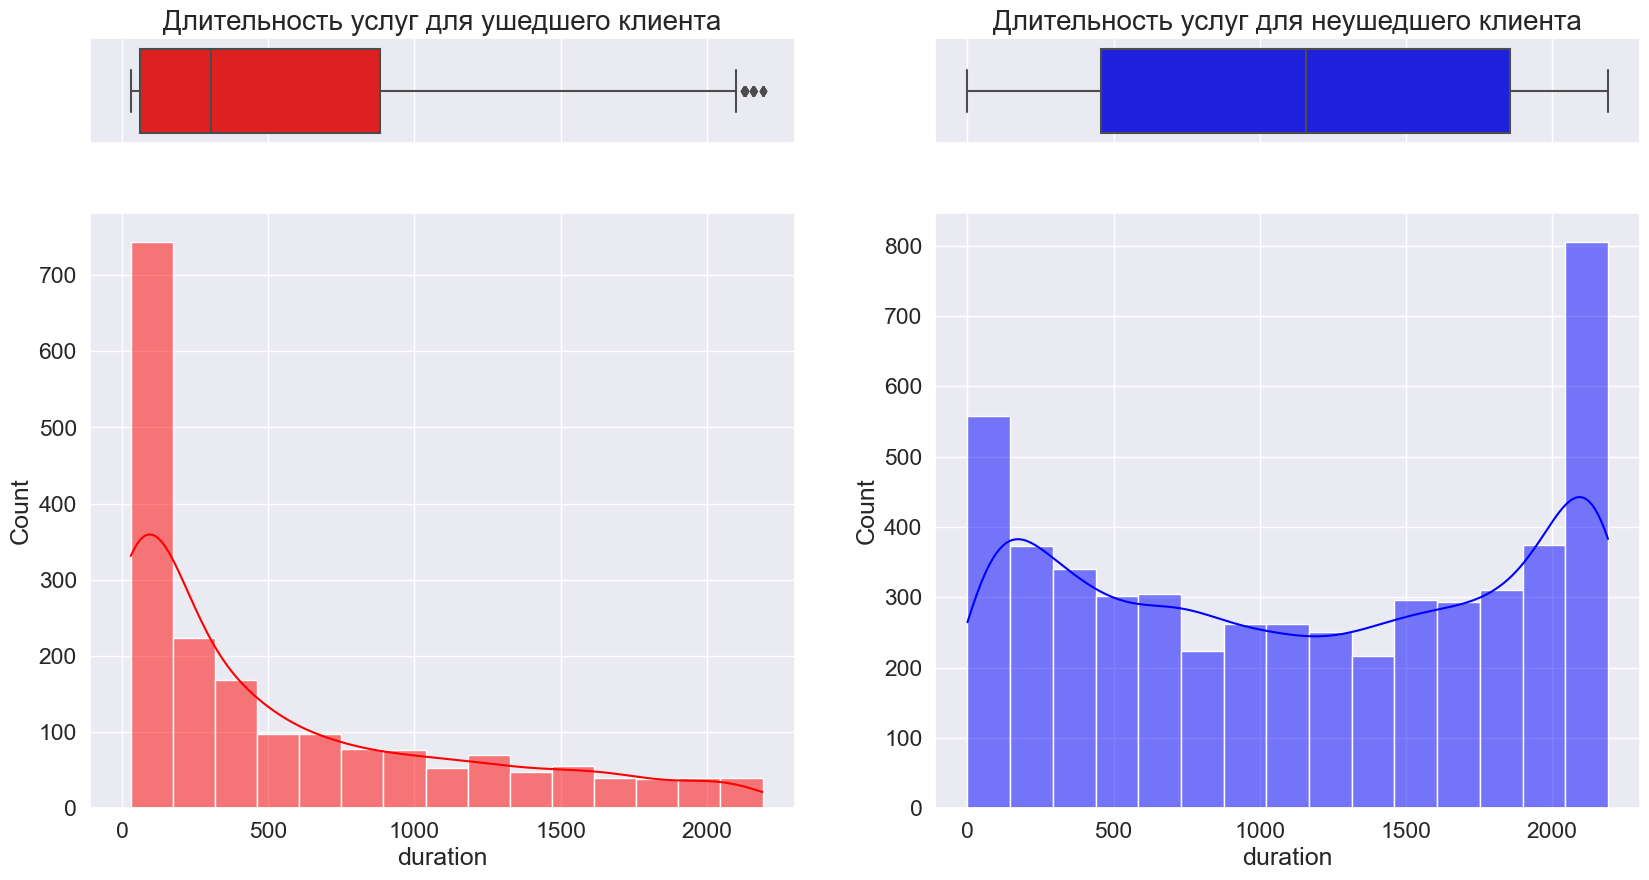

In [46]:
sns.set(font_scale=1.5)
f, (ax_box, ax_hist) = plt.subplots(2, 2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20, 10))

sns.boxplot(data=df_terminated, x="duration", ax=ax_box[0], color='red').set_title('Длительность услуг для ушедшего клиента', size=20)
sns.histplot(data=df_terminated, x="duration", kde=True, color='red', ax=ax_hist[0], bins=15)

sns.boxplot(data=df_not_terminated, x="duration", ax=ax_box[1], color='blue').set_title('Длительность услуг для неушедшего клиента', size=20)
sns.histplot(data=df_not_terminated, x="duration", kde=True, color='blue', ax=ax_hist[1], bins=15)

ax_box[0].set(xlabel='')
ax_box[1].set(xlabel='')

plt.show()

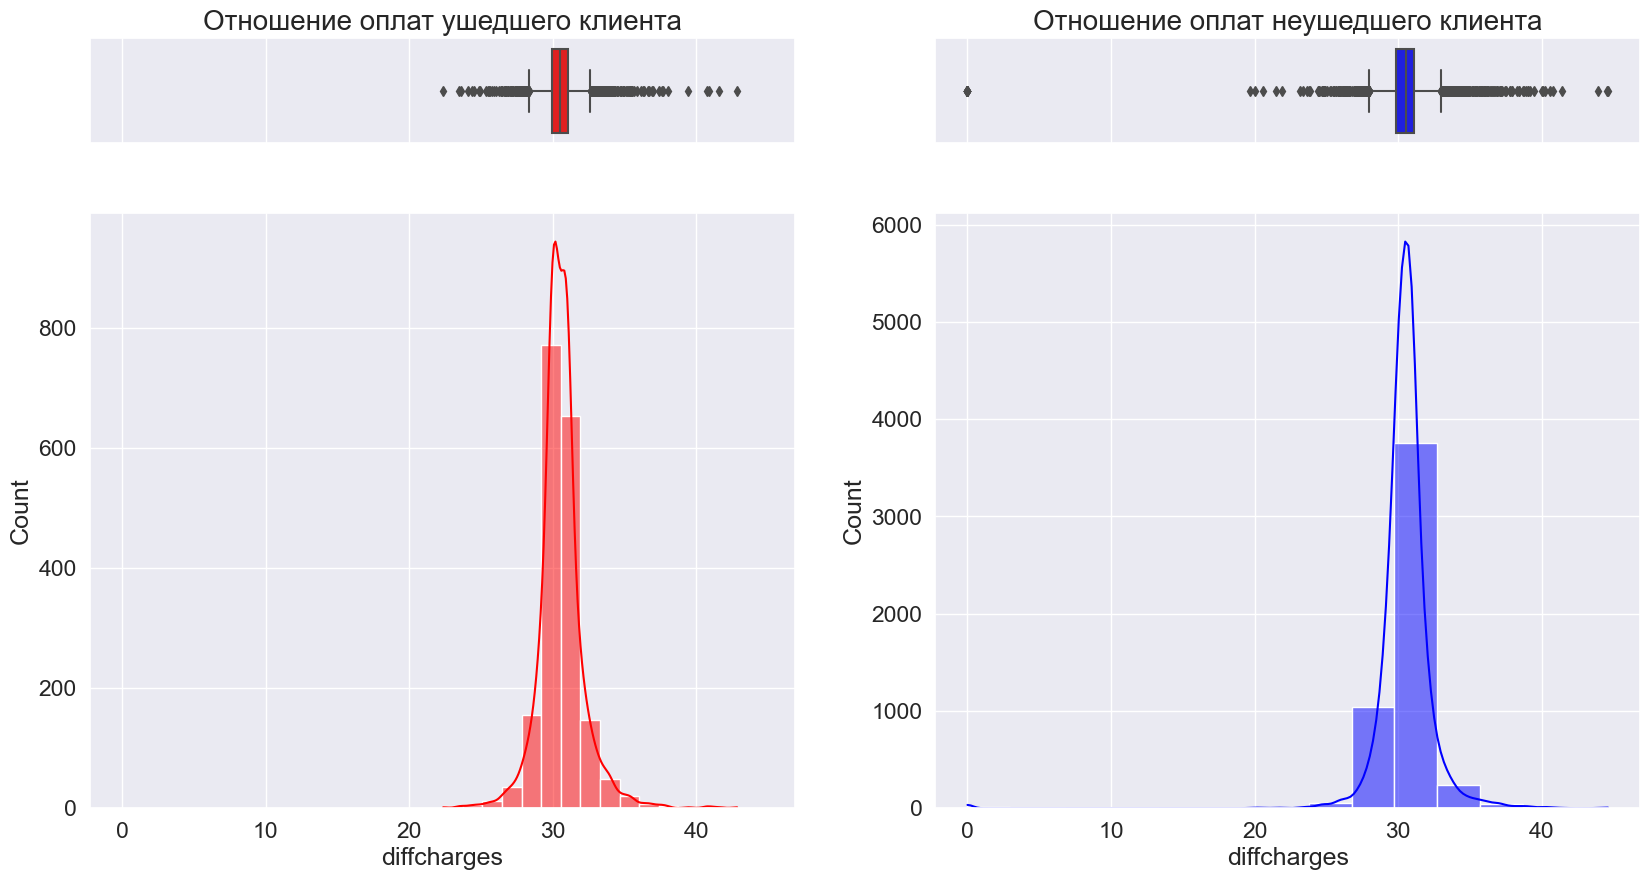

In [47]:
sns.set(font_scale=1.5)
f, (ax_box, ax_hist) = plt.subplots(2, 2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20, 10))

sns.boxplot(data=df_terminated, x="diffcharges", ax=ax_box[0], color='red').set_title('Отношение оплат ушедшего клиента', size=20)
sns.histplot(data=df_terminated, x="diffcharges", kde=True, color='red', ax=ax_hist[0], bins=15)

sns.boxplot(data=df_not_terminated, x="diffcharges", ax=ax_box[1], color='blue').set_title('Отношение оплат неушедшего клиента', size=20)
sns.histplot(data=df_not_terminated, x="diffcharges", kde=True, color='blue', ax=ax_hist[1], bins=15)

ax_box[0].set(xlabel='')
ax_box[1].set(xlabel='')

plt.show()

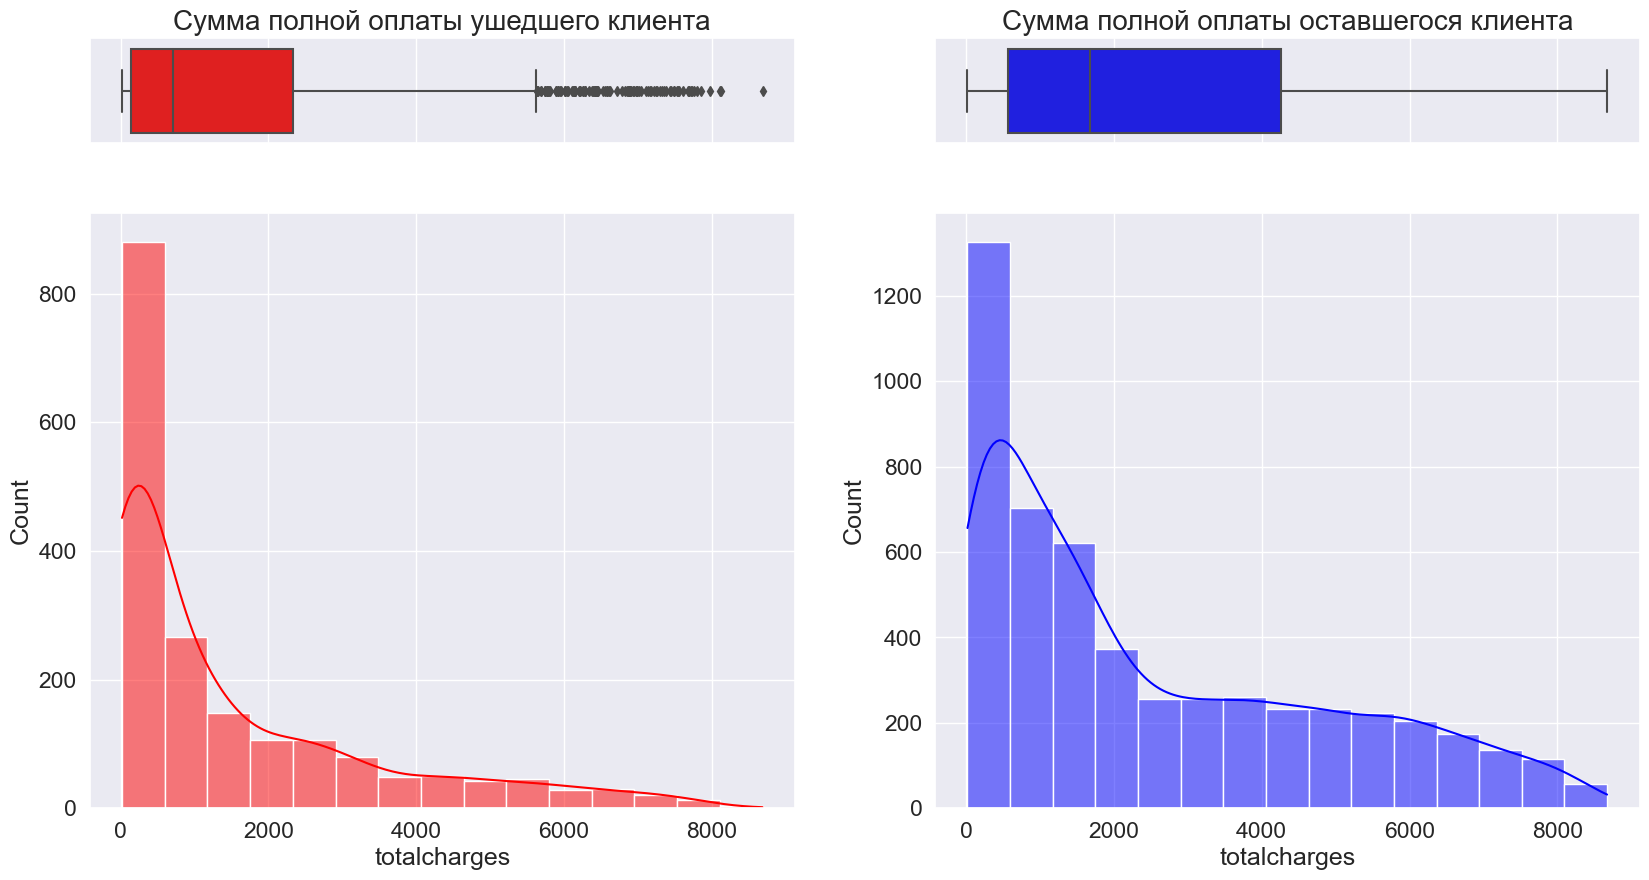

In [48]:
sns.set(font_scale=1.5)
f, (ax_box, ax_hist) = plt.subplots(2, 2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20, 10))

sns.boxplot(data=df_terminated, x="totalcharges", ax=ax_box[0], color='red').set_title('Сумма полной оплаты ушедшего клиента', size=20)
sns.histplot(data=df_terminated, x="totalcharges", kde=True, color='red', ax=ax_hist[0], bins=15)

sns.boxplot(data=df_not_terminated, x="totalcharges", ax=ax_box[1], color='blue').set_title('Сумма полной оплаты оставшегося клиента', size=20)
sns.histplot(data=df_not_terminated, x="totalcharges", kde=True, color='blue', ax=ax_hist[1], bins=15)

ax_box[0].set(xlabel='')
ax_box[1].set(xlabel='')

plt.show()

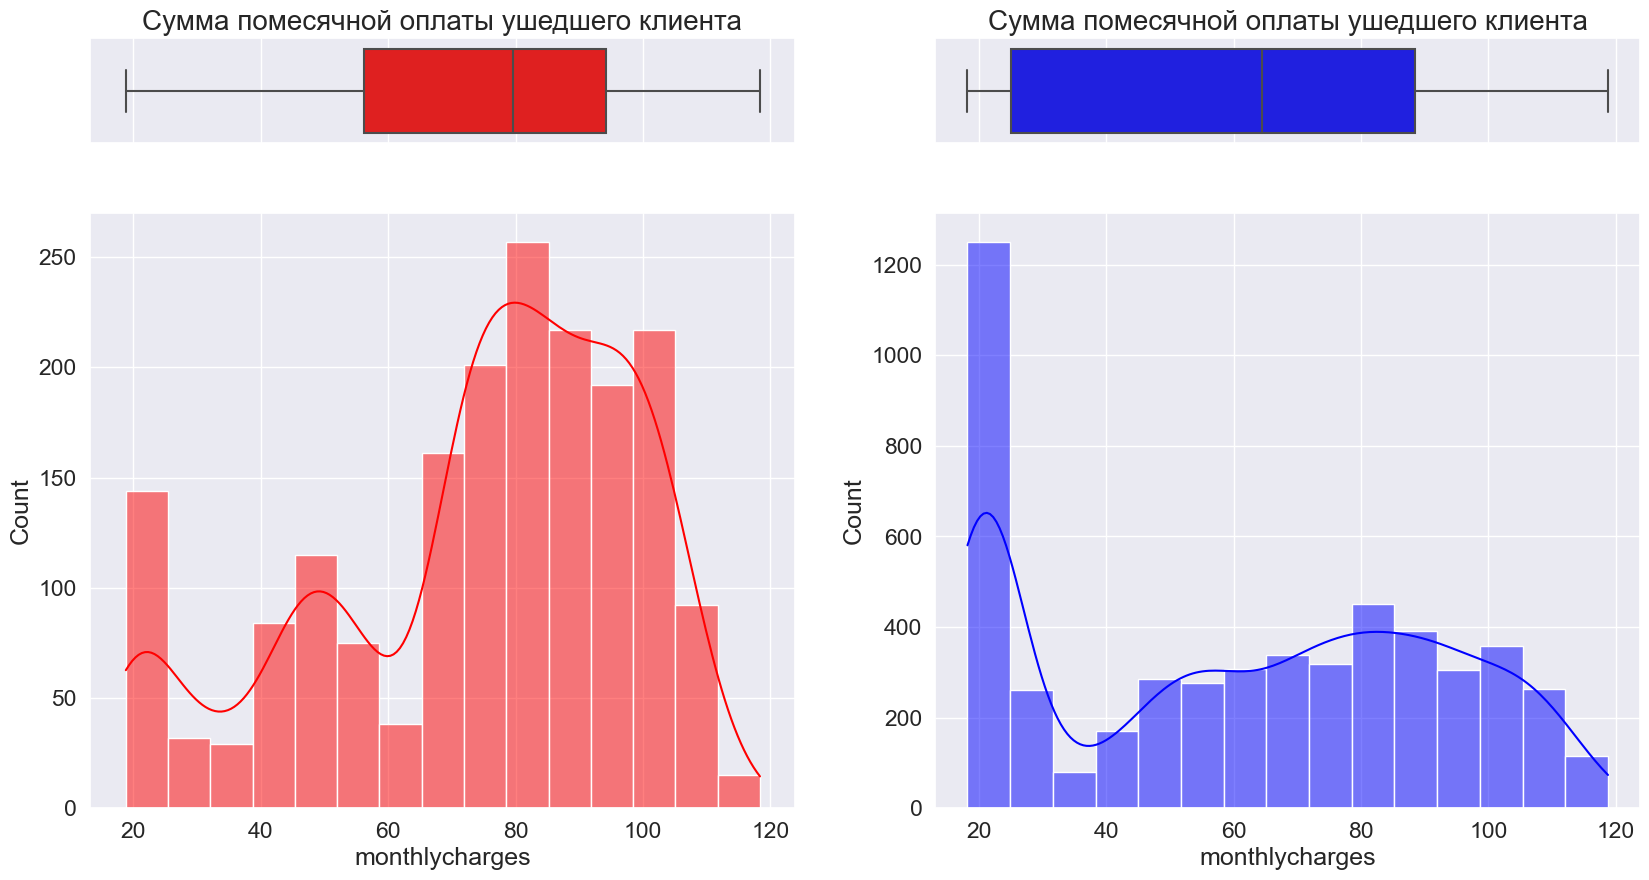

In [49]:
sns.set(font_scale=1.5)
f, (ax_box, ax_hist) = plt.subplots(2, 2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20, 10))

sns.boxplot(data=df_terminated, x="monthlycharges", ax=ax_box[0], color='red').set_title('Сумма помесячной оплаты ушедшего клиента', size=20)
sns.histplot(data=df_terminated, x="monthlycharges", kde=True, color='red', ax=ax_hist[0], bins=15)

sns.boxplot(data=df_not_terminated, x="monthlycharges", ax=ax_box[1], color='blue').set_title('Сумма помесячной оплаты ушедшего клиента', size=20)
sns.histplot(data=df_not_terminated, x="monthlycharges", kde=True, color='blue', ax=ax_hist[1], bins=15)

ax_box[0].set(xlabel='')
ax_box[1].set(xlabel='')

plt.show()

Длительность услуг для ушедших и оставшихся клиентов имеет непохожие распределения, вероятно будет хорошим признаком для будущей модели. Для ушедших клиентов имеются выбросы, это самые первые клиенты.

Отношение средней помесячной и текущей помесячной оплат имеют похожие распределения и выбросы. После обучения проверим, хорший ли признак сгенерирован, удалив признак и переобучив заново модель. Есть подозрения что можно обойтись без этого признака.  

Распределения помесячной платы в некоторых местах схожи(большое кол-во пользователей в районе минимума),местами все же различны и у них нет выбросов. Скорее признак будет полезный.  

Полная оплата имеет похожие распределения. Сказывается ли он на качестве обучения проверим тем же путем, что и отношение оплат.

#### Исследуем категориальные признаки для 2-ух групп.

In [50]:
df_category = df.select_dtypes(include='object').columns.to_list()

In [51]:
df_terminated.loc[df_terminated['paymentmethod']=='Bank transfer (automatic)', 'paymentmethod'] = 'Bank transfer'
df_not_terminated.loc[df_not_terminated['paymentmethod']=='Bank transfer (automatic)', 'paymentmethod'] = 'Bank transfer'
df_terminated.loc[df_terminated['paymentmethod']=='Credit card (automatic)', 'paymentmethod'] = 'Credit card'
df_not_terminated.loc[df_not_terminated['paymentmethod']=='Credit card (automatic)', 'paymentmethod'] = 'Credit card'

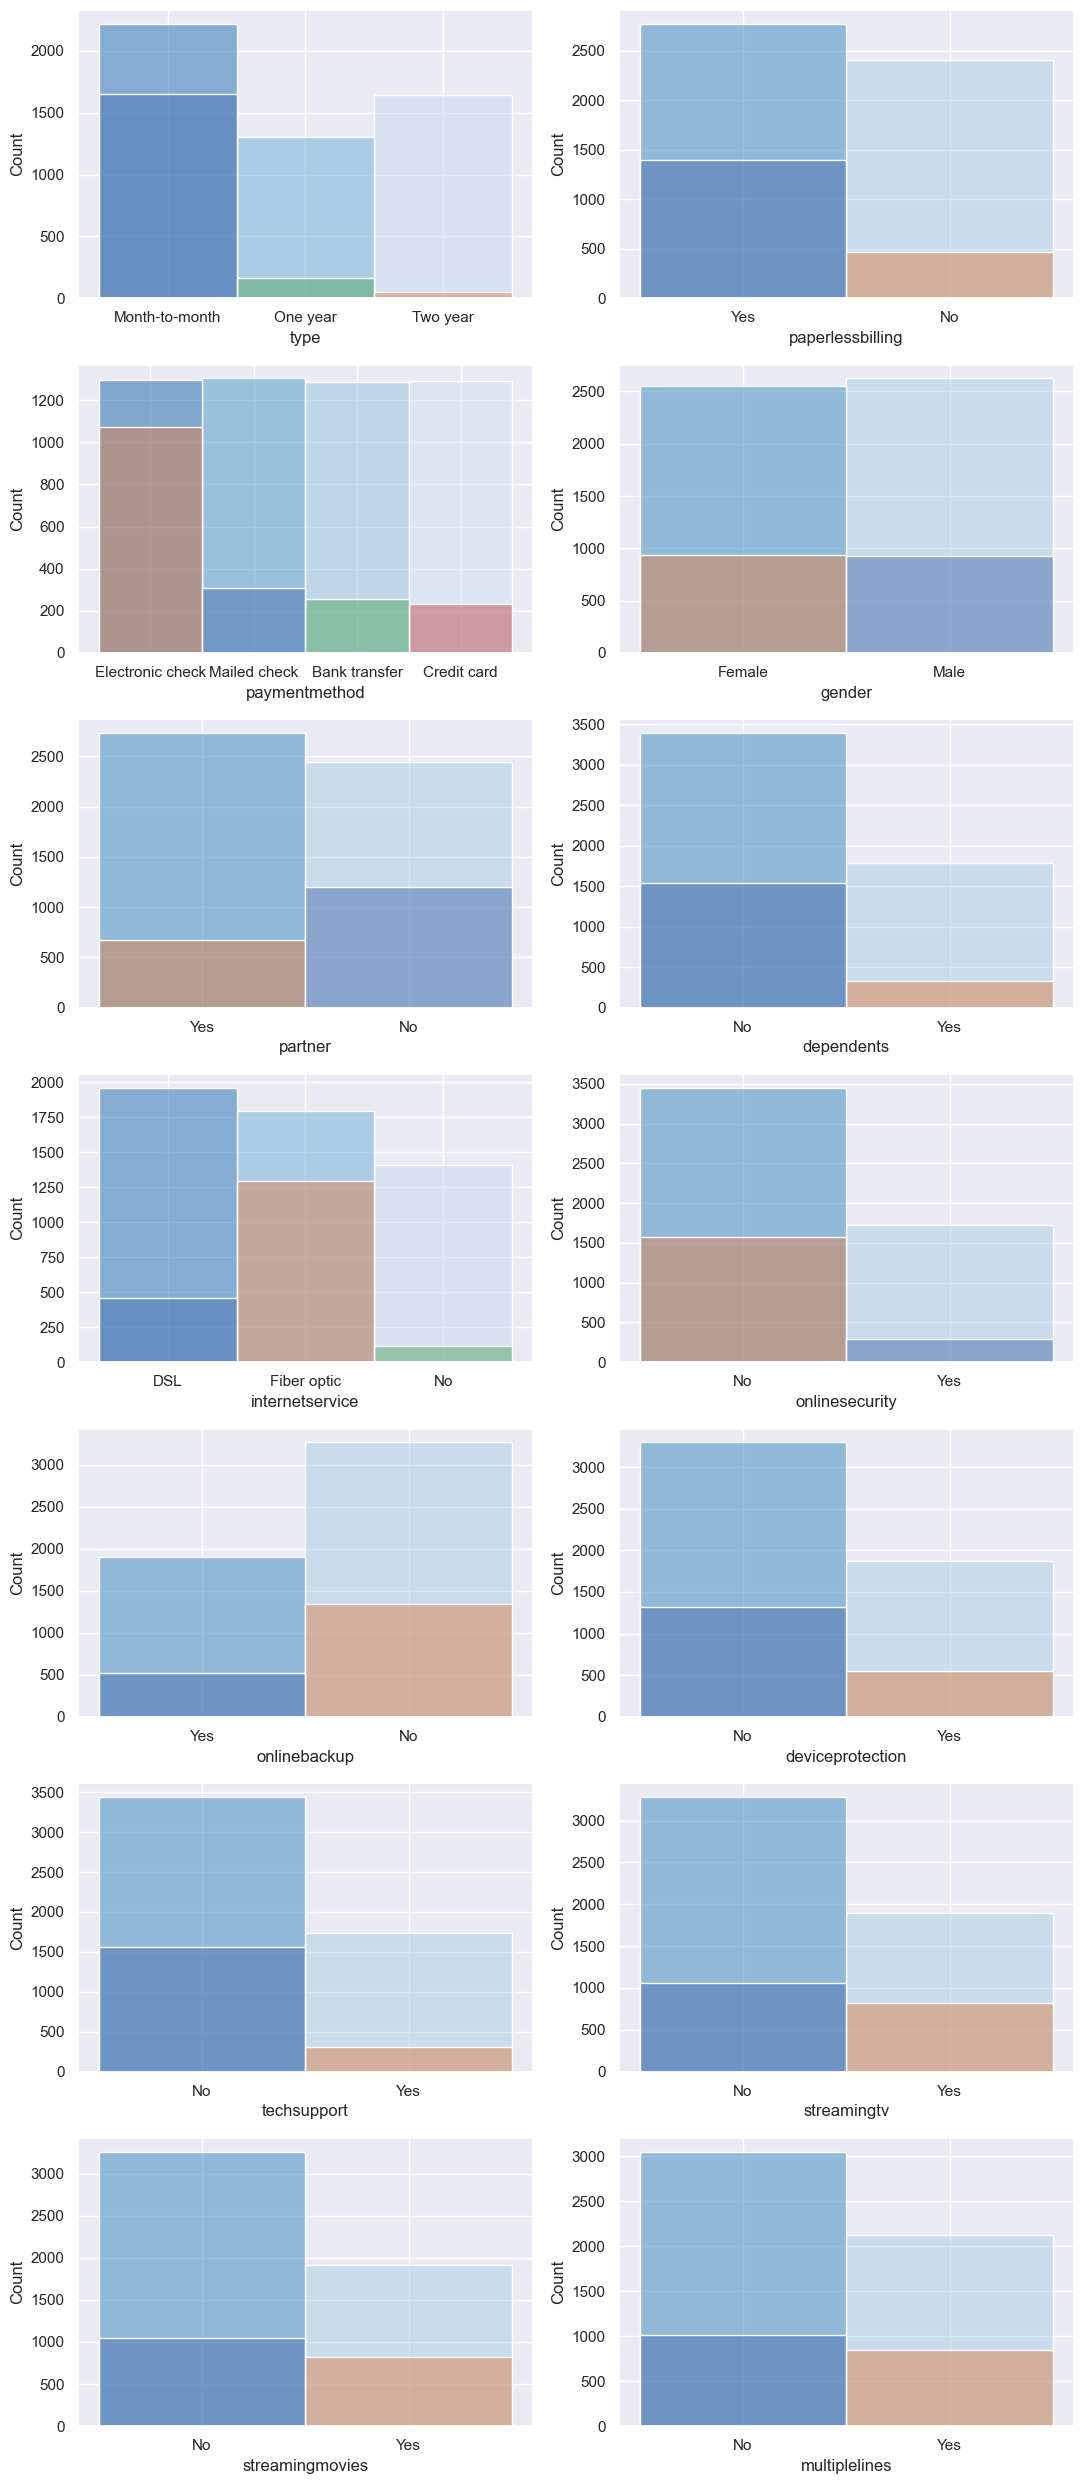

In [78]:
sns.set(font_scale=1)
fig = plt.figure(figsize=(11,25))

for i, cat in zip(range(len(df_category)), df_category):
    fig.add_subplot(7, 2, i+1)
    sns.histplot(df_not_terminated, x=cat, hue=cat, legend=False, alpha=0.5, palette='Blues_r') 
    sns.histplot(df_terminated, x=cat, hue=cat, legend=False)    
    plt.tight_layout()

Для ушедших клиентов наиболее характерен помесячный тип оплаты и оплата электронным счетом в сравнении с другими типами и способами оплаты. Тажке стоит обратить внимание, что среди ушедших у большего числа потребителей подключение было через оптоволоконную линию. Возможна как и проблема со скоростью/стабильностью, а также, что телефонные услуги выгодны, и возможность пользоваться обычным телефоном и подключенным к интернету компьютером нравится пользователям.

Реже всего расторгает договор категория пользующаяся только телефонной связью (без интернета). Тажке почти не уходят пользователи, которые предпочитают тип оплаты на два года, что вполне ясно: клиенты, предпочитающие платить за 2 года вперед определены в выборе провайдера.

По информации о клиентах непросто сделать вывод о том, какие категории чаще отказываются от услуг. Соотношение групп ушедших и неушедших без особых различий. Например, для признака "пол" кажется, что соотношение ушедших и неушедших абсолютно не различается.
Наличие партнера для двух групп различно. Cреди группы ушедших чаще встречается категория клиентов "без партнера". Среди неушедших - "c партнером".

По некоторым признакам действительно хорошо видно, что проблема в определенной услуге

### Исследуем корреляцию, проведем отбор признаков

Будем удалять признаки только в случае, когда между двумя числовыми признаками имеется сильная корелляция.  
При наличии слабой корреляции признаков с целевым, зафиксируем их, обучим модель, затем удалим их и посмотрим как это сказалось на качестве предсказаний.  



In [53]:
matrix_phik = df.phik_matrix().round(2)

interval columns not set, guessing: ['monthlycharges', 'totalcharges', 'seniorcitizen', 'terminated', 'duration', 'diffcharges']


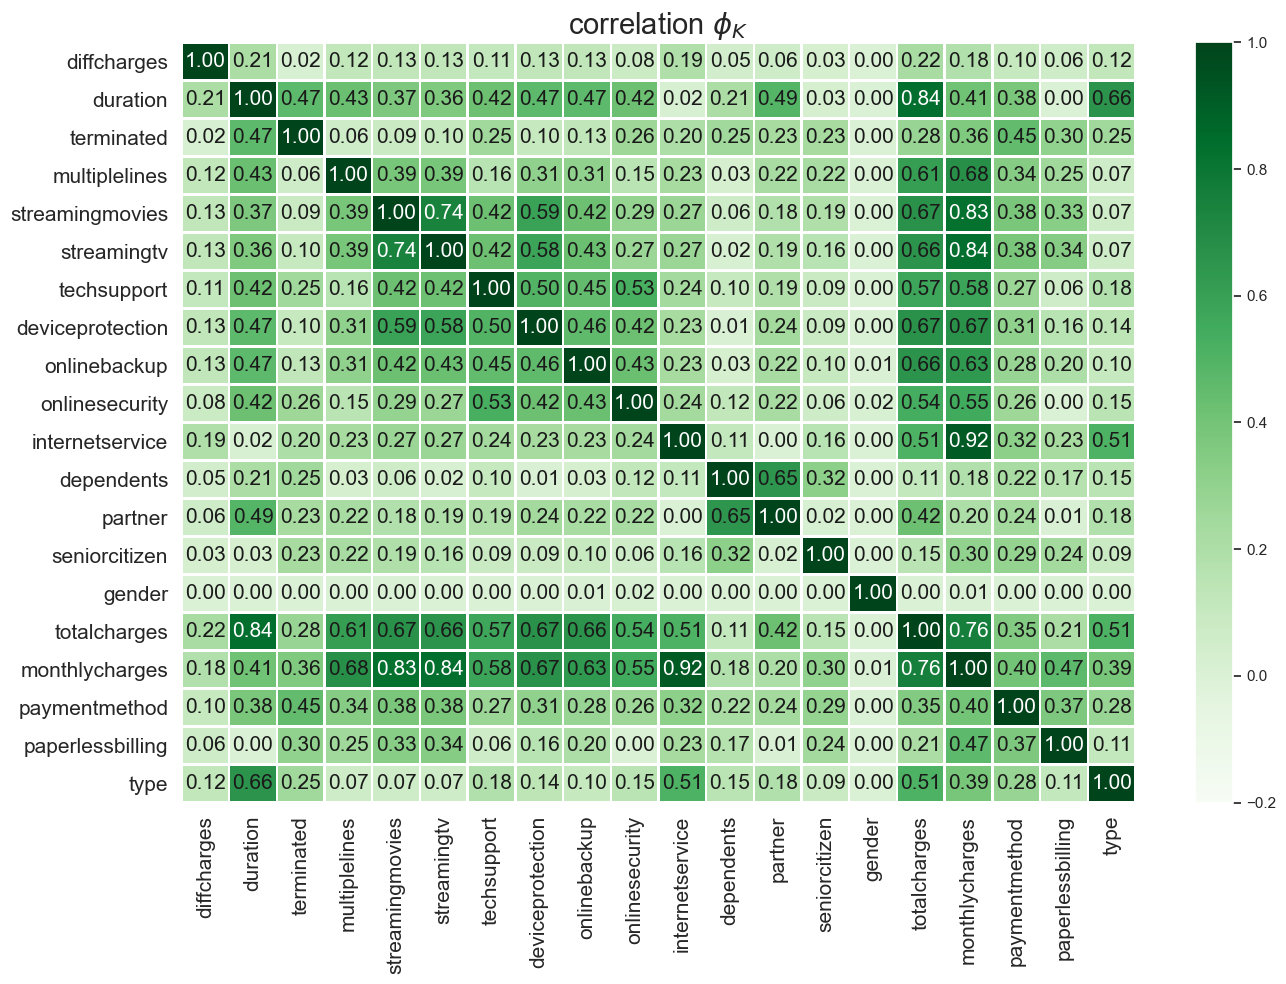

In [54]:
plot_correlation_matrix(matrix_phik.values, 
                        x_labels=matrix_phik.columns, 
                        y_labels=matrix_phik.index, 
                        vmin=-0.2, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(14, 10))
plt.tight_layout()

In [55]:
df = df.drop('totalcharges', axis=1)

Сильно коррелируют  "streamingmovies", "streamingTV", "internetserviсе" с "monthlycharges". Также высокая корреляция у  "streamingmovies" и "streamingTV".

Сильная корреляция у сгенерированного "duration" и "totalcharges". Удалим второй. Также высокая корреляция у "totalcharges" и "monthlycharges".

С целевым слабо коррелируют признаки: "onlinesecurity", "gender", "seniorcitizen", "paperlesspilling".

#### Предварительно обратим внимание на такие признаки, как: "monthlycharges", "onlinesecurity", "gender", "seniorcitizen", "paperlesspilling", "streamingmovies".

## Обучение модели



### Разделим данные на тренировочную и тестовую выборки

Зафиксируем random_state согласно условию

In [56]:

RANDOM_STATE = 270223

X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop('terminated', axis=1), 
                                    df['terminated'], 
                                    test_size=0.25, 
                                    stratify=df['terminated'], 
                                    shuffle=True, 
                                    random_state=RANDOM_STATE)

### Обучим модели
* LogisticRegression и  DesicionTreeClassifier
* LightGBM

#### LogisticRegression и  DesicionTreeClassifier

In [57]:
preprocessing_1 = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    (StandardScaler(), make_column_selector(dtype_include=['int64', 'float64'])), 
    remainder ='passthrough'
)


In [58]:
preprocessing_2 = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), make_column_selector(dtype_include=object)), 
    remainder ='passthrough'
)

In [59]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
#Step 1. Define an objective function to be maximized.
def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = Pipeline(steps=[("preprocessor", preprocessing_1), ("clf_reg", LogisticRegression(C=logreg_c, random_state=RANDOM_STATE))])
    else:
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = Pipeline(steps=[("preprocessor", preprocessing_2), ("clf_tree", RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=RANDOM_STATE))])

    # Step 3: Scoring method:
    score = cross_val_score(classifier_obj, X_train, y_train, scoring='roc_auc', n_jobs=-1, cv=5)
    roc_auc = score.mean()
    return roc_auc

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30);

In [60]:
print(f"Лучшее значение ROC_AUC : \n{study.best_value}")
print()
print(f"Лучшие параметры модели : \n{study.best_params}")

Лучшее значение ROC_AUC : 
0.8572304132883295

Лучшие параметры модели : 
{'classifier': 'RandomForest', 'rf_n_estimators': 736, 'rf_max_depth': 8}


#### LgbmClassifier

In [61]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
     # Step 2. Setup values for the hyperparameters:
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        #"reg_lambda": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "seed": RANDOM_STATE
    }
    # Step 3: Scoring method:
    score = cross_val_score(lgb.LGBMClassifier(**param), X_train.astype({it:'category' for it in df_category}), y_train, scoring='roc_auc', n_jobs=-1, cv=5)
    roc_auc = score.mean()
    
    return roc_auc

# Step 4: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=200)

In [62]:
print(f"Лучшее значение ROC AUC : \n{study.best_value}")
print()
print(f"Лучшие параметры модели : \n{study.best_params}")

Лучшее значение ROC AUC : 
0.9057294784039751

Лучшие параметры модели : 
{'reg_alpha': 0.12014269223290495, 'num_leaves': 44, 'colsample_bytree': 0.41097606148766563, 'subsample': 0.9697439124369615, 'subsample_freq': 5, 'min_child_samples': 6}


#### По показателям ключевой метрики "ROC AUC" лучшей оказалась "LgbmClassifier".  
Изучим остальные метрики классификации.

In [63]:
# Функция для матрицы ошибок на кросс-валидации

originalclass = []
predictedclass = []

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) 

In [64]:
rf_clf = Pipeline(steps=[("preprocessor", preprocessing_2), ("tree", RandomForestClassifier(
            max_depth=10, n_estimators=575, random_state=RANDOM_STATE))])

lgb_clf = lgb.LGBMClassifier(**study.best_trial.params, random_state=RANDOM_STATE)

In [65]:
rf_score = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass)) 

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3880
           1       0.72      0.53      0.61      1402

    accuracy                           0.82      5282
   macro avg       0.78      0.73      0.75      5282
weighted avg       0.81      0.82      0.81      5282



In [66]:
lgb_score = cross_val_score(lgb_clf, X_train.astype({it:'category' for it in df_category}), y_train, cv=5,
                            scoring=make_scorer(classification_report_with_accuracy_score),  n_jobs=-1)
print(classification_report(originalclass, predictedclass)) 

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3880
           1       0.72      0.53      0.61      1402

    accuracy                           0.82      5282
   macro avg       0.78      0.73      0.75      5282
weighted avg       0.81      0.82      0.81      5282



#### Остальные метрици классификации похожи. Лучшая модель - "LgbmClassifier".

<a id='5'></a>
## Итоговое тестирование модели

### Оценка важности признаков модели.

In [67]:
lgb_clf.fit(X_train.astype({it:'category' for it in df_category}), y_train);

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

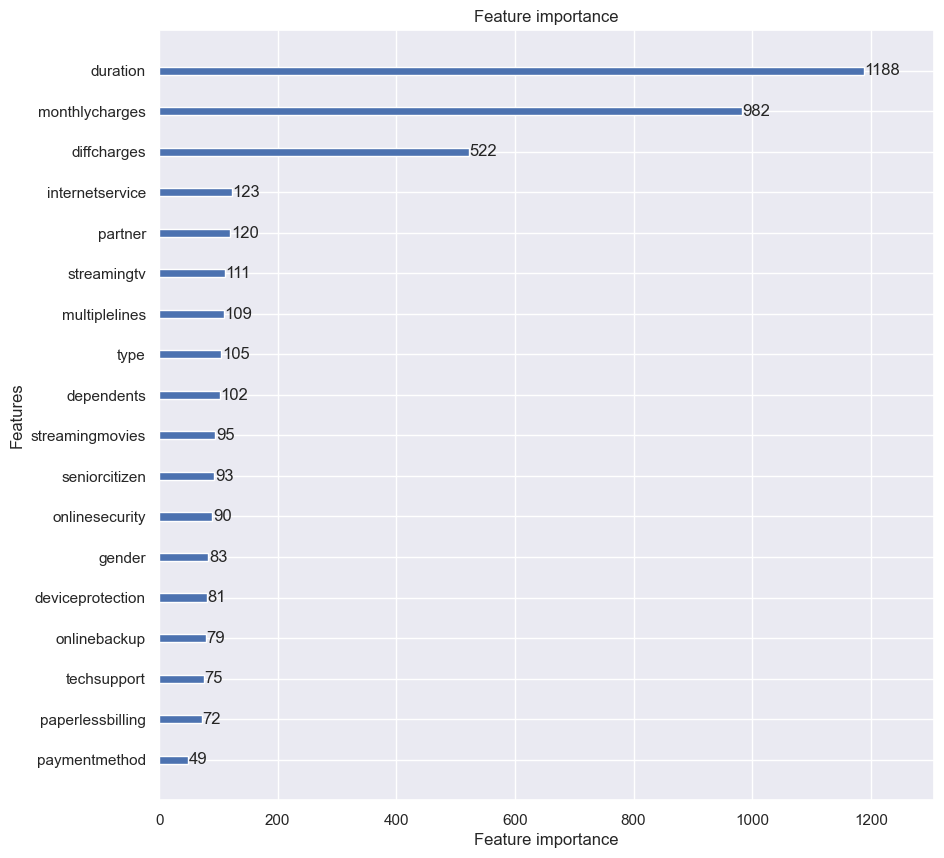

In [68]:
lgb.plot_importance(lgb_clf, figsize=(10, 10))

Анализ важности признаков позволяет не только построить лучшую модель и уменьшить число признаков для обучения. Мы также можем выдать рекомендации бизнесу, изучив влияние признаков на отток, тем самым можно повысить качество определенных услуг, например онлайн-платежи или интернет на оптоволокне.

Некоторые признаки оказались менее важными, удалим их, заново обучим модель. Примем во внимание выводы из [исследовательского анализа](#4).

In [69]:
df_new = df.drop(columns=['streamingmovies', 'gender', 'monthlycharges', 'seniorcitizen', 'paperlessbilling', 'onlinesecurity'])
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
                                    df_new.drop('terminated', axis=1), 
                                    df_new['terminated'], 
                                    test_size=0.25, 
                                    stratify=df['terminated'], 
                                    shuffle=True, 
                                    random_state=RANDOM_STATE)
df_new_category =  df_new.select_dtypes(include='object').columns.to_list()

Между признаком 'gender' и целевым отсуствует корреляция. Это характерно и для признаков 'seniorcitizen',  'paperlessbilling', 'onlinesecurity'. Важность данных признаков невысока.  
'streamingmovies' сильно скоррелирован с 'streamingTV'.    
У 'monthlycharges' сильная корреляция с некоторыми категориальными признаками.  


In [70]:
lgb_clf.fit(X_new_train.astype({it:'category' for it in df_new_category}), y_new_train);

In [71]:
total_report = cross_val_score(lgb_clf, X_train.astype({it:'category' for it in df_category}), y_train, cv=5, \
                               scoring=make_scorer(classification_report_with_accuracy_score),  n_jobs=-1)

print(classification_report(originalclass, predictedclass)) 

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3880
           1       0.72      0.53      0.61      1402

    accuracy                           0.82      5282
   macro avg       0.78      0.73      0.75      5282
weighted avg       0.81      0.82      0.81      5282



In [72]:
total_ROC_AUC = cross_val_score(lgb_clf, X_train.astype({it:'category' for it in df_category}), \
                                y_train, cv=5, scoring="roc_auc",  n_jobs=-1).mean()

print('ROC AUC: ', total_ROC_AUC)

ROC AUC:  0.9057294784039751


#### Удалено 6 признаков, потери качества модели нет. 

### Оценка модели на контрольной выборке

In [73]:
predict_pr = lgb_clf.predict_proba(X_new_test.astype({it:'category' for it in df_new_category}))
predict_pr = predict_pr[:, 1]
total_metric = roc_auc_score(y_new_test, predict_pr)

In [74]:
predict =  lgb_clf.predict(X_new_test.astype({it:'category' for it in df_new_category}))
print(classification_report(y_new_test, predict)) 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1294
           1       0.83      0.62      0.71       467

    accuracy                           0.87      1761
   macro avg       0.85      0.79      0.81      1761
weighted avg       0.86      0.87      0.86      1761



In [75]:
print('ROC AUC: ', total_metric)

ROC AUC:  0.9150659111895124


#### Модель показала хорошие результаты на тестовой выборке. 

<a id='6'></a>
## Вывод

Лучшая моделью для предсказания оттока клиентов среди используемых в проекте - "LightGBMClassifier" c гиперпараметрами:
{'reg_alpha': 0.12014269223290495, 'num_leaves': 44, 'colsample_bytree': 0.41097606148766563, 'subsample': 0.9697439124369615, 'subsample_freq': 5, 'min_child_samples': 6}.  
Лучшее значение ключевой метрики ROC AUC - 0.91, лучшее значение дополнительной метрики accuracy - 0.82.  
При итоговом тестировании модели ROC AUC - 0.92, accuracy - 0.87.


<a id='7'></a>
## Отчет о проделанной работе

В ходе выполнения проектной работы были выполнены все основные шаги из плана работ. Подпункт 3.2.2 плана "Применим     "upsampling" для учета дисбаланса классов" пункта 3 "Обучение модели" не нашел применения, дисбаланс классов не повлиял на качество предсказаний модели.  

При объединении датафреймов появились пропуски в данных об интернет-услугах и наличии многоканальной связи. Изучив  их, мы сделали вывод, что пропуски в различных видах услуг есть в связи с тем, что клиенты ими не пользуются.
Пропуски заполнили категориальным значением "No".  
 Другой вид пропусков имел место до объединения датафреймов. Отсутвтвовали даты в данных о дате расторжения договора. При отсутствии даты клиента считали неушедшим.  
Также отсуствовала целевая переменная.Она сгенерирована из переменной "enddate" - дата расторжения договора. 
Если клиент расторг договор ее значение - "1", если нет - "0".

Аномальных значений, требующих удаления в данных, не обнаружено.  

Для воспроиводимости расчетов параметр "random_state" принят равным "270223".

Данные поделены на обучающую и тестовую выборку, где тестовая составляет 25% от исходных данных.

Оценка модели проводится с помощью кросс-валидации, количество частей для перекрестной проверки - 5.

Высокого значения ROC-AUC  добились с помощью модели градиентного бустинга "LightGBMClassifier".  
Также рассмотрены модели "RandomForestClassifier" и "LogisticRegression". Они оказались несколько хуже.

Перед обучением предварительно закодировали категориальные признаки с помощью "OneHotEncoder", для линейной модели масштабировали числовые признаки с помощью "StandartScaller".  

Для модели "LightGBMClassifier" были подобраны гиперпараметры с помощью фреймворка "optuna", что положительно сказалось на значении нашей метрики. Итоговые параметры модели : 'reg_alpha': 0.12014269223290495, 'num_leaves': 44, 'colsample_bytree': 0.41097606148766563, 'subsample': 0.9697439124369615, 'subsample_freq': 5, 'min_child_samples': 6.  

Генерация дополнительных признаков положительно сказалась на качестве предсказаний. Cгенерированы такие признаки,как "duration" - длительность оказания услуг и "diffcharges" - отношение оплаты на текущий месяц и средней помесячной оплаты.  
Удалены признаки, которые дали бы утечку целевой переменной "enddate" и "begindate".

Проведена оценка важности признаков лучшей модели. Определены наименее важные признаки, и впоследствие удалены. Обосновать удаление признаков помог исследовательский анализ данных(матрица корреляции, изучение распределения признаков для двух категорий:1-клиент ушел, 2-клиент остался). Удалены признаки 'streamingmovies', 'gender', 'monthlycharges', 'seniorcitizen', 'paperlessbilling', 'onlinesecurity'. На качестве модели удаление не сказалось, производительность улучшилась.  
Итоговый набор признаков: 'type', 'paymentmethod', 'partner', 'dependents', 'internetservice','onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv','multiplelines', 'terminated', 'duration', 'diffcharges'.

Лучшее значение ключевой метрики ROC-AUC - 0.91, лучшее значение дополнительной метрики accuracy - 0.82.
При итоговом тестировании модели ROC-AUC - 0.92, accuracy - 0.87.
Поставленная задача предсказания оттока клиентов с метрикой ROC-AUC > 0,85 решена.